# 1. Data Preperation

In [23]:
import geopandas as gpd
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS

In [24]:
#Load pre-existing park data
parks_lst_gdf = gpd.read_file('Data/Riyadh_parks_with_LST.geojson')
print("Loaded parks_gdf with columns:", parks_lst_gdf.columns) 

Loaded parks_gdf with columns: Index(['osm_id', 'OBJECTID', 'FEATURE_ANAME', 'MUNICIPALITY', 'DISTRICT',
       'WALKING_TRACK', 'GREEN_AREAS', 'LAYERID', 'LAYERANAME', 'Validation',
       'Park_id', 'area_m2', 'perimeter_m', 'LSI', 'ndvi_mean',
       'ndvi_pixel_count', 'pisi_mean', 'pisi_pixel_count', 'lst_buffer_30m',
       'lst_buffer_60m', 'lst_buffer_90m', 'lst_buffer_120m',
       'lst_buffer_150m', 'lst_buffer_180m', 'lst_buffer_210m',
       'lst_buffer_240m', 'lst_buffer_270m', 'lst_buffer_300m', 'lst_park',
       'park_pixel_count', 'lst_data', 'cubic_coeffs', 'r_squared', 'PCD',
       'PCI', 'PCA', 'PCE', 'geometry'],
      dtype='object')


## Checking parks selection criteria

In [43]:
# Create a new DataFrame to avoid modifying the original
filtered_parks_gdf = parks_lst_gdf.copy()

In [44]:
# Extract centroids for distance calculation
centroids = filtered_parks_gdf.copy()
centroids['geometry'] = centroids.geometry.centroid

# Initialize a set to track parks to remove (both from each close pair)
parks_to_remove = set()

# Calculate pairwise distances and identify close pairs (<300m)
for i, park1 in centroids.iterrows():
    for j, park2 in centroids.iterrows():
        if i < j:  # Avoid duplicate pairs and self-comparison
            dist = park1.geometry.distance(park2.geometry)
            if dist < 300:  # 300m threshold based on max buffer radius
                parks_to_remove.add(park1['Park_id'])
                parks_to_remove.add(park2['Park_id'])

# Remove both parks from each close pair
filtered_parks_gdf = filtered_parks_gdf[~filtered_parks_gdf['Park_id'].isin(parks_to_remove)]

# Summary of changes
num_removed = len(parks_lst_gdf) - len(filtered_parks_gdf)
print(f"Number of parks removed: {num_removed}")
print(f"Original number of parks: {len(parks_lst_gdf)}")
print(f"New number of parks: {len(filtered_parks_gdf)}")
print(f"Removed Park IDs: {sorted(list(parks_to_remove))}")

Number of parks removed: 25
Original number of parks: 221
New number of parks: 196
Removed Park IDs: [21.0, 26.0, 38.0, 41.0, 50.0, 63.0, 64.0, 65.0, 69.0, 75.0, 77.0, 79.0, 80.0, 83.0, 84.0, 87.0, 88.0, 89.0, 114.0, 137.0, 140.0, 154.0, 169.0, 170.0, 182.0]


In [46]:
# Categorize cooling vs. heating parks
cooling_parks = filtered_parks_gdf[filtered_parks_gdf['PCI'] < 0].shape[0]
heating_parks = filtered_parks_gdf[filtered_parks_gdf['PCI'] >= 0].shape[0]
total_parks = len(filtered_parks_gdf)
print(f"\nCooling Parks (PCI < 0): {cooling_parks} ({cooling_parks/total_parks*100:.1f}%)")
print(f"Heating Parks (PCI >= 0): {heating_parks} ({heating_parks/total_parks*100:.1f}%)")



Cooling Parks (PCI < 0): 56 (28.6%)
Heating Parks (PCI >= 0): 140 (71.4%)


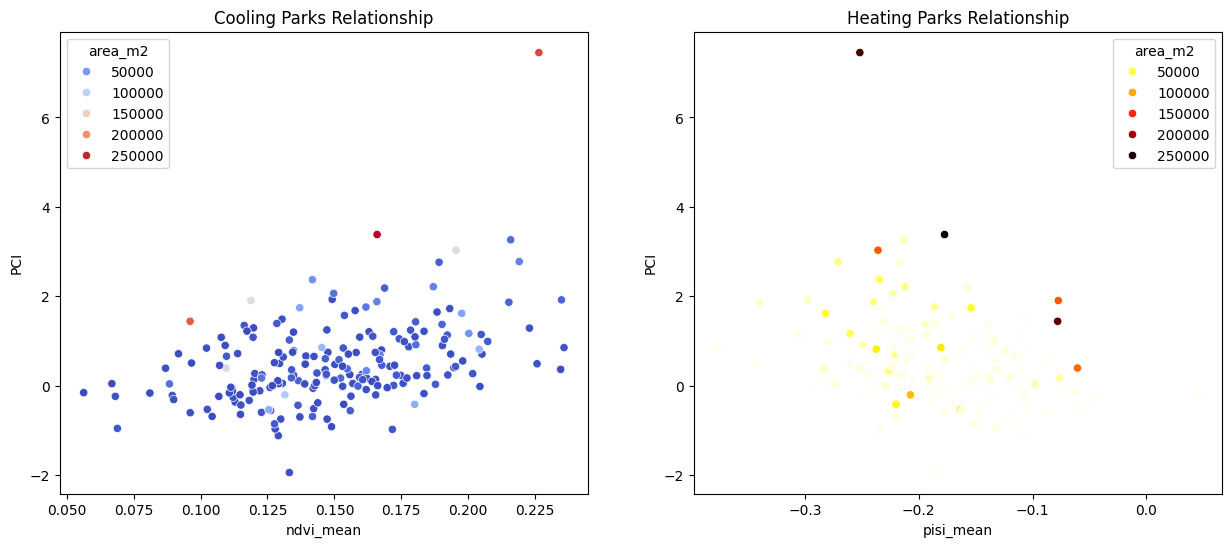

In [47]:
# Visualize fundamental differences
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(data=filtered_parks_gdf, x='ndvi_mean', y='PCI', hue='area_m2', ax=ax[0], palette='coolwarm')
ax[0].set_title('Cooling Parks Relationship')
sns.scatterplot(data=filtered_parks_gdf, x='pisi_mean', y='PCI', hue='area_m2', ax=ax[1], palette='hot_r')
ax[1].set_title('Heating Parks Relationship')
plt.show()

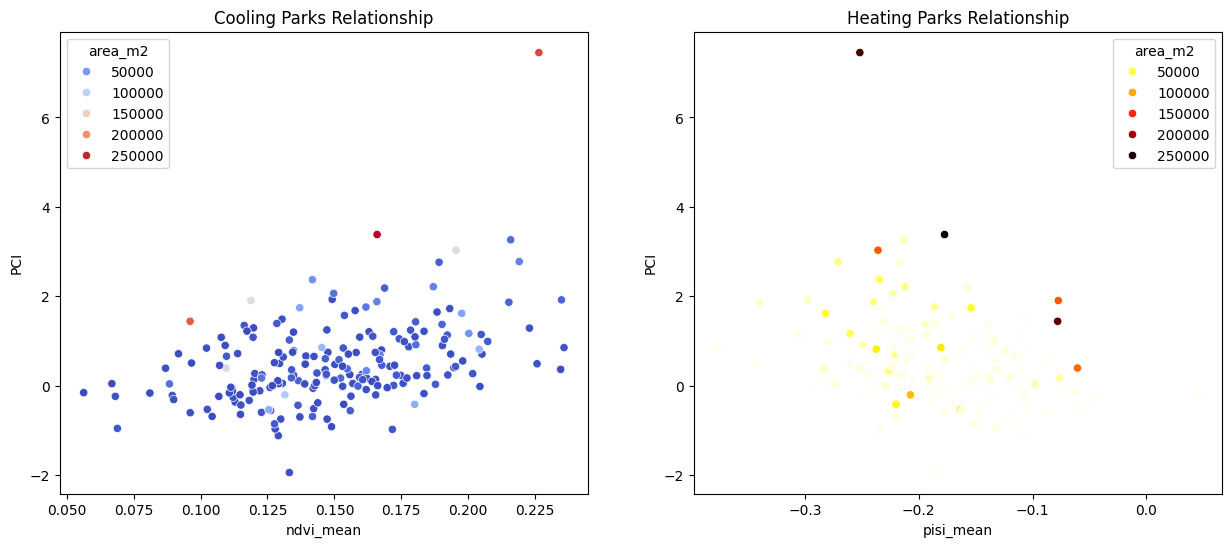

In [48]:
# Visualize fundamental differences
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(data=filtered_parks_gdf, x='ndvi_mean', y='PCI', hue='area_m2', ax=ax[0], palette='coolwarm')
ax[0].set_title('Cooling Parks Relationship')
sns.scatterplot(data=filtered_parks_gdf, x='pisi_mean', y='PCI', hue='area_m2', ax=ax[1], palette='hot_r')
ax[1].set_title('Heating Parks Relationship')
plt.show()

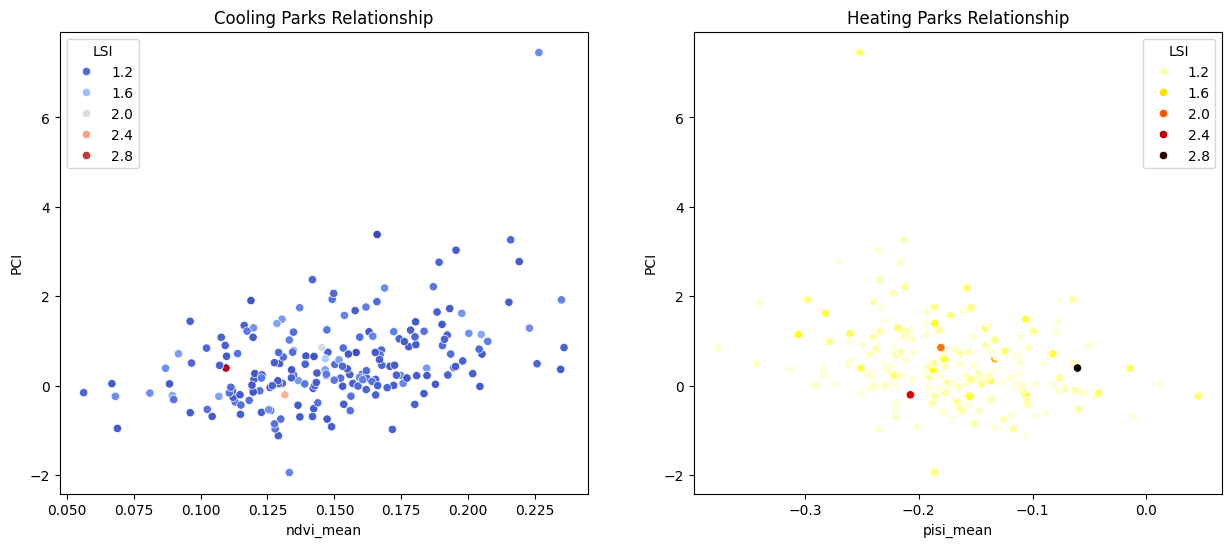

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(data=filtered_parks_gdf, x='ndvi_mean', y='PCI', hue='LSI', ax=ax[0], palette='coolwarm')
ax[0].set_title('Cooling Parks Relationship')
sns.scatterplot(data=filtered_parks_gdf, x='pisi_mean', y='PCI', hue='LSI', ax=ax[1], palette='hot_r')
ax[1].set_title('Heating Parks Relationship')
plt.show()

In [6]:
# data_df_cooling = data_df['PCI'].apply(lambda x: 'Cooling' if x < 0 else 'Heating')

# 2. Initial Exploration

This section performs Pearson correlation analysis to explore the influence of various factors on LST metrics preliminarily

In [56]:
# Select relevant columns for the analysis
data_df = filtered_parks_gdf[['ndvi_mean', 'pisi_mean', 'area_m2', 'LSI', 'PCI', 'PCA', 'PCE']].copy() ## Create a copy of the specified columns to avoid SettingWithCopyWarning

In [58]:
correlations = data_df.corr()
p_values = pd.DataFrame(index=data_df.columns, columns=data_df.columns)
for col1 in data_df.columns:
    for col2 in data_df.columns:
        corr, p_val = stats.pearsonr(data_df[col1], data_df[col2])
        p_values.loc[col1, col2] = p_val

print("\nPearson Correlation Coefficients:")
print(correlations.round(3))
print("\nP-Values for Correlation Significance:")
print(p_values.round(3))


Pearson Correlation Coefficients:
           ndvi_mean  pisi_mean  area_m2    LSI    PCI    PCA    PCE
ndvi_mean      1.000     -0.800    0.097 -0.107  0.428  0.048 -0.263
pisi_mean     -0.800      1.000   -0.046  0.100 -0.261  0.039  0.336
area_m2        0.097     -0.046    1.000  0.258  0.518  0.505 -0.341
LSI           -0.107      0.100    0.258  1.000  0.030  0.386 -0.169
PCI            0.428     -0.261    0.518  0.030  1.000  0.399 -0.149
PCA            0.048      0.039    0.505  0.386  0.399  1.000  0.087
PCE           -0.263      0.336   -0.341 -0.169 -0.149  0.087  1.000

P-Values for Correlation Significance:
          ndvi_mean pisi_mean   area_m2       LSI       PCI       PCA  \
ndvi_mean       0.0       0.0  0.176982   0.13554       0.0  0.503509   
pisi_mean       0.0       0.0  0.524225  0.163224  0.000216  0.590115   
area_m2    0.176982  0.524225       0.0  0.000264       0.0       0.0   
LSI         0.13554  0.163224  0.000264       0.0  0.674109       0.0   
PCI     

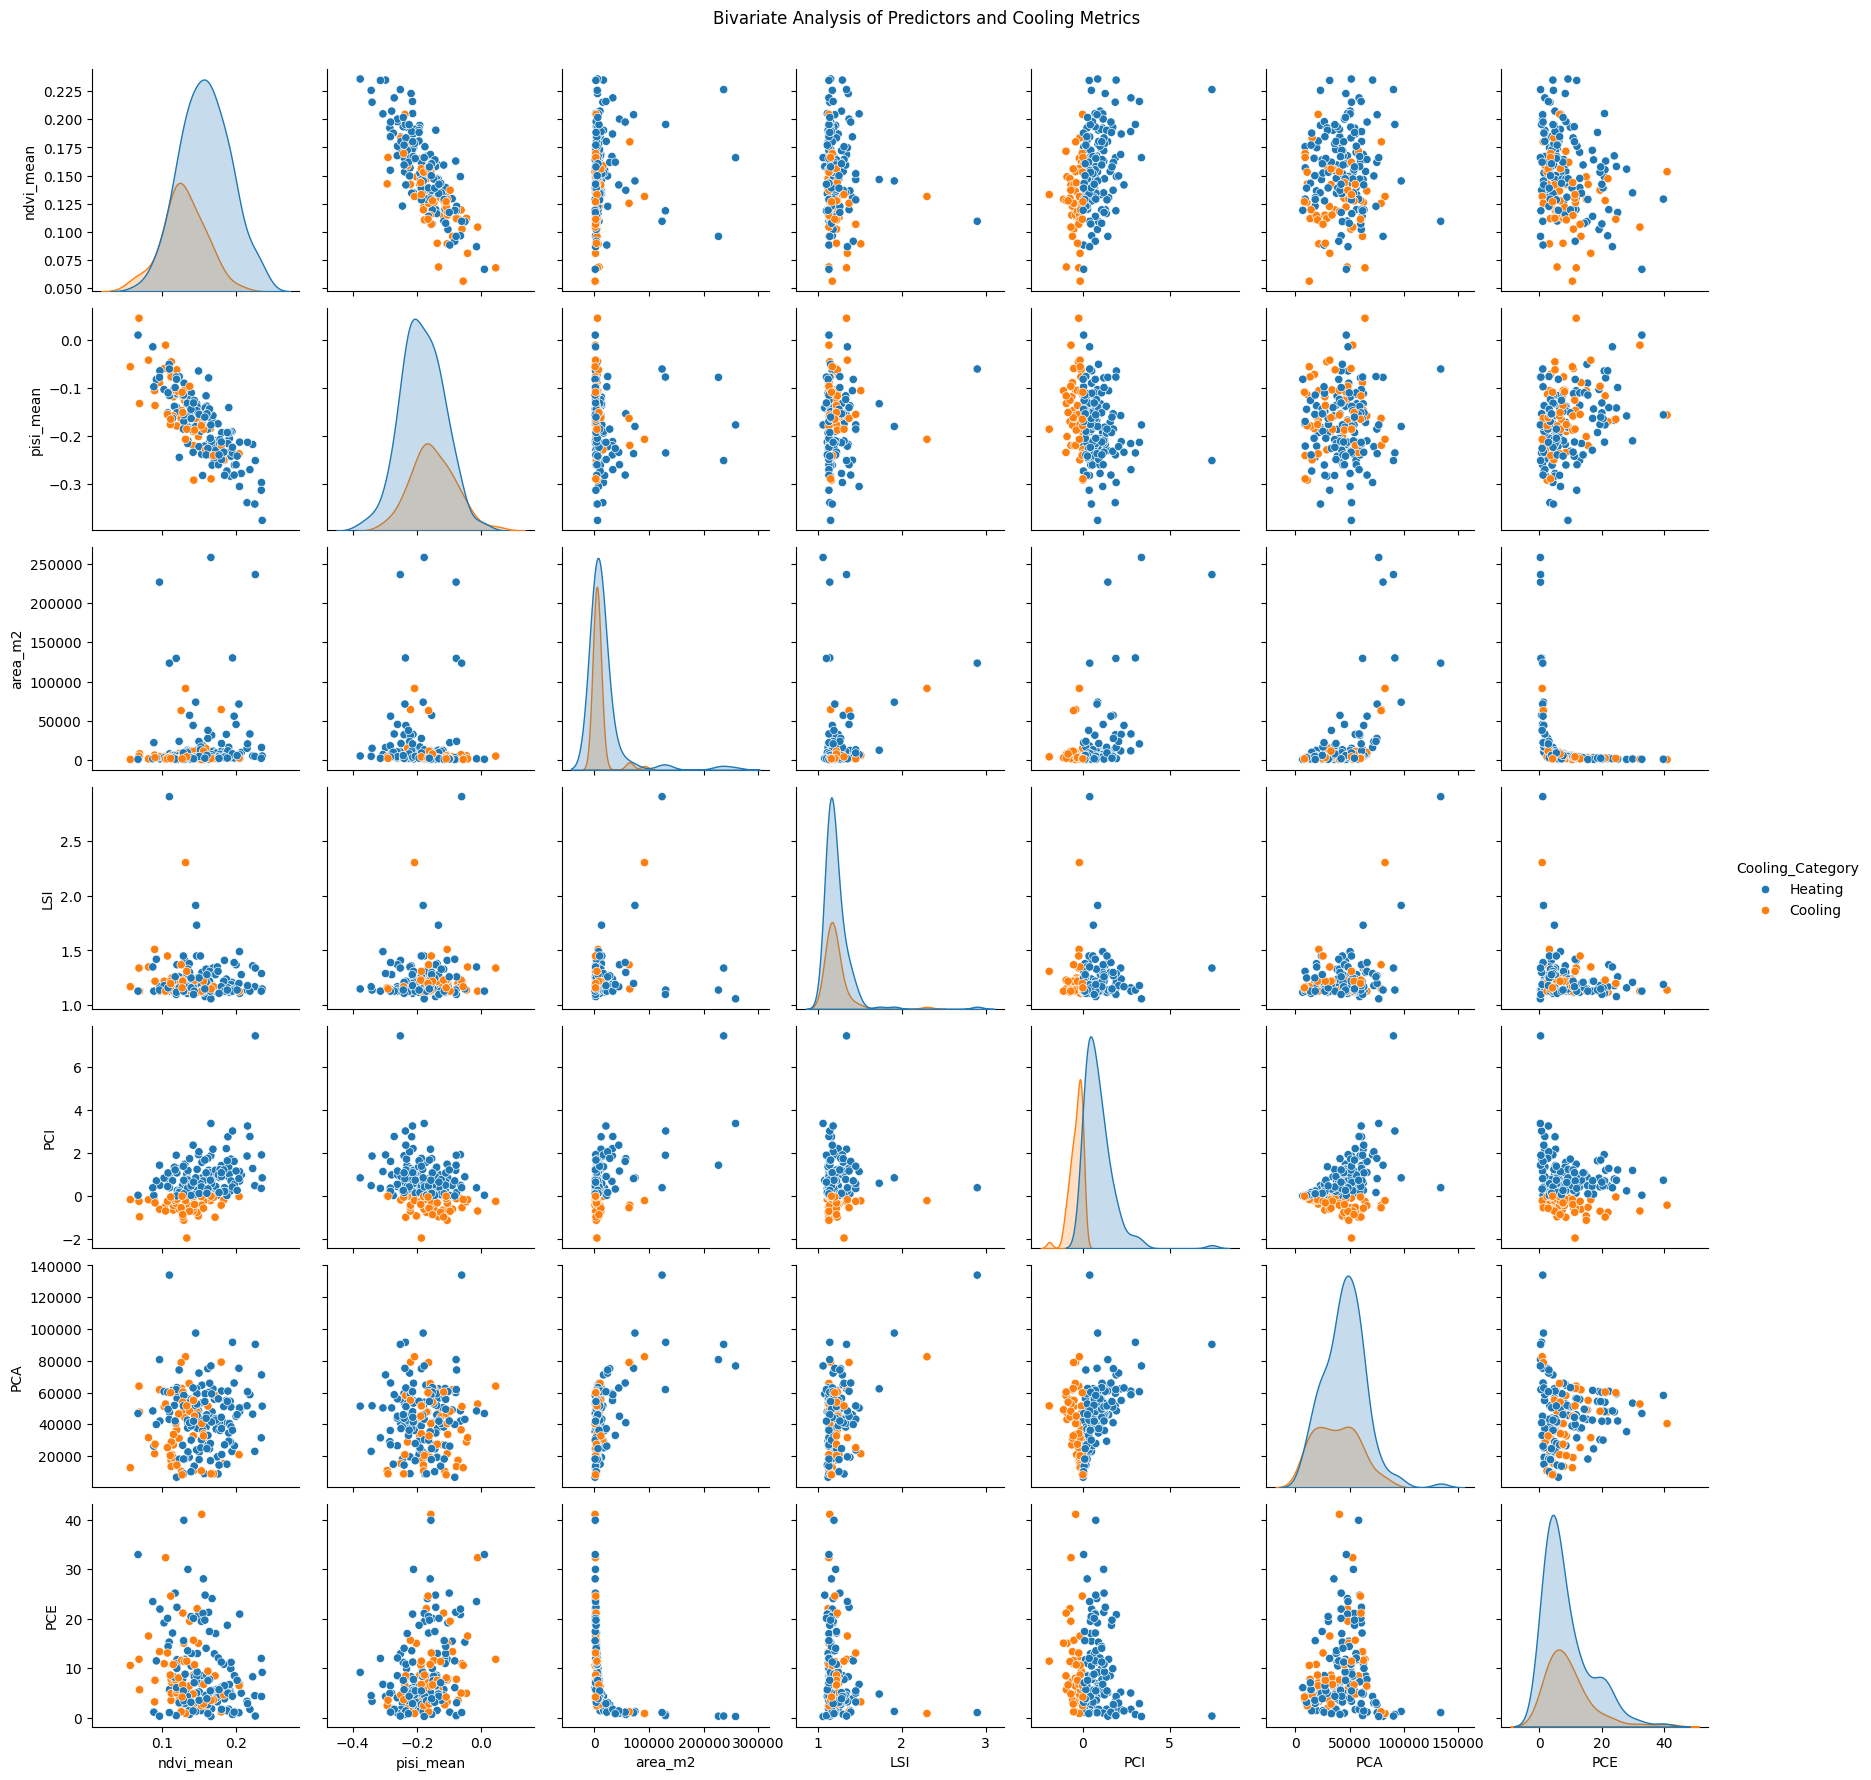

In [59]:
data_df['PCI'] = pd.to_numeric(data_df['PCI'], errors='coerce')  # Convert to numeric

# Add hue column for cooling/heating categorization
data_df['Cooling_Category'] = data_df['PCI'].apply(lambda x: 'Cooling' if x < 0 else 'Heating')

# Bivariate analysis with corrected hue
sns.pairplot(data_df, hue='Cooling_Category', vars=['ndvi_mean', 'pisi_mean', 'area_m2', 'LSI', 'PCI', 'PCA', 'PCE'], diag_kind='kde')
plt.suptitle('Bivariate Analysis of Predictors and Cooling Metrics', y=1.02)
plt.show()

In [53]:
print(len(data_df))

221


# 3. Regression Analysis

## 3.1. Model 1

From the correlation matrix, ndvi_mean and pisi_mean show strong negative correlation (r = -0.802), including both in the same model will cause multicollinearity problems (unstable coefficients, inflated standard errors)

In [60]:
# Create the subset where 'PCI' is less than 0
data_df_cooling = data_df[data_df['PCI'] < 0].copy()
data_df_heating = data_df[data_df['PCI'] > 0].copy()

print(f"Number of parks with cooling effect: {len(data_df_cooling)}")
print(f"Number of parks with heating effect: {len(data_df_heating)}")

Number of parks with cooling effect: 56
Number of parks with heating effect: 140



===== Cooling Parks - PCI Model =====
                            OLS Regression Results                            
Dep. Variable:                    PCI   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.065
Method:                 Least Squares   F-statistic:                    0.1632
Date:                Thu, 24 Jul 2025   Prob (F-statistic):              0.956
Time:                        01:44:10   Log-Likelihood:                -22.842
No. Observations:                  56   AIC:                             55.68
Df Residuals:                      51   BIC:                             65.81
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

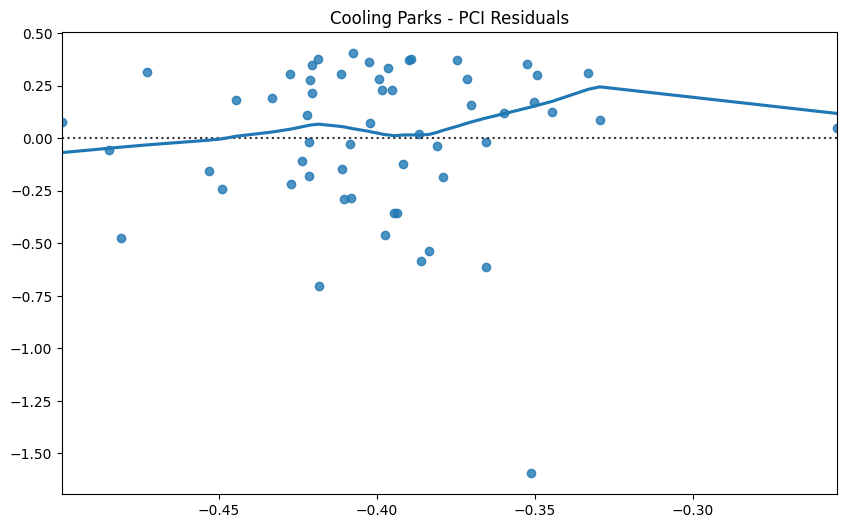


===== Cooling Parks - PCA Model =====
                            OLS Regression Results                            
Dep. Variable:                    PCA   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     6.837
Date:                Thu, 24 Jul 2025   Prob (F-statistic):           0.000174
Time:                        01:44:10   Log-Likelihood:                -621.31
No. Observations:                  56   AIC:                             1253.
Df Residuals:                      51   BIC:                             1263.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5

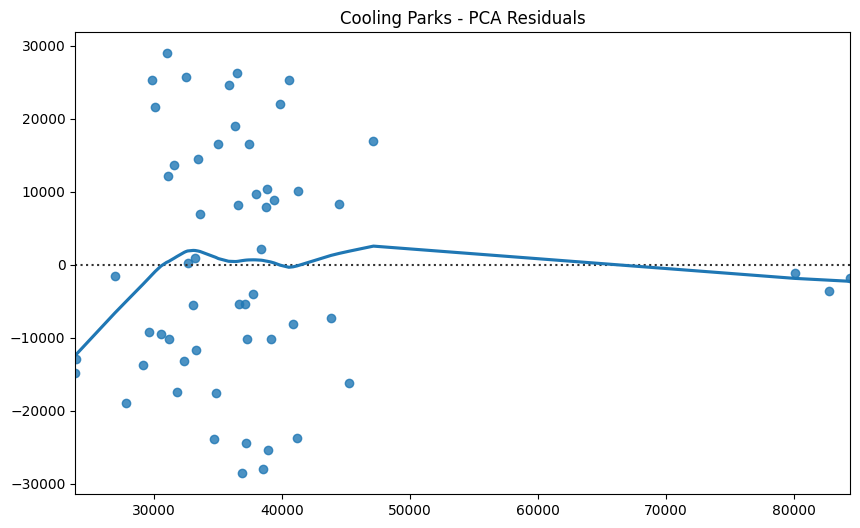


===== Cooling Parks - PCE Model =====
                            OLS Regression Results                            
Dep. Variable:                    PCE   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     2.752
Date:                Thu, 24 Jul 2025   Prob (F-statistic):             0.0379
Time:                        01:44:10   Log-Likelihood:                -187.43
No. Observations:                  56   AIC:                             384.9
Df Residuals:                      51   BIC:                             395.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

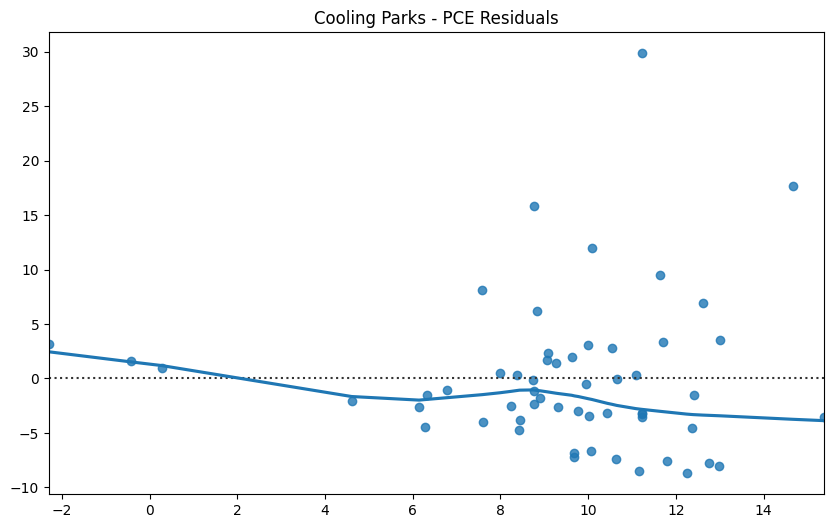


===== Heating Parks - PCI Model =====
                            OLS Regression Results                            
Dep. Variable:                    PCI   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     27.46
Date:                Thu, 24 Jul 2025   Prob (F-statistic):           1.10e-16
Time:                        01:44:11   Log-Likelihood:                -141.83
No. Observations:                 140   AIC:                             293.7
Df Residuals:                     135   BIC:                             308.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

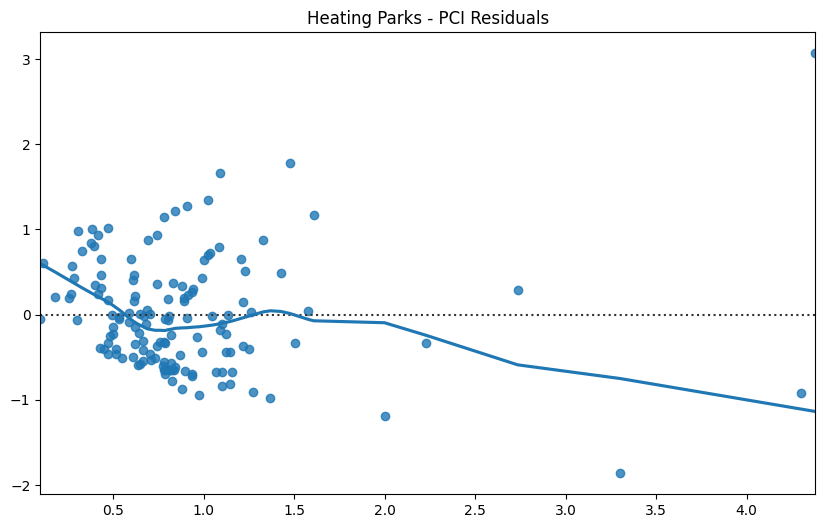


===== Heating Parks - PCA Model =====
                            OLS Regression Results                            
Dep. Variable:                    PCA   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     20.14
Date:                Thu, 24 Jul 2025   Prob (F-statistic):           5.03e-13
Time:                        01:44:11   Log-Likelihood:                -1547.3
No. Observations:                 140   AIC:                             3105.
Df Residuals:                     135   BIC:                             3119.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1

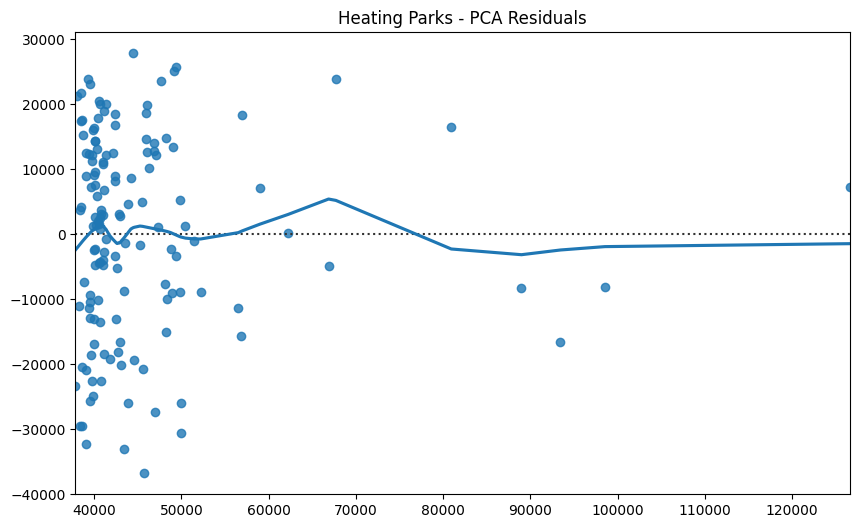


===== Heating Parks - PCE Model =====
                            OLS Regression Results                            
Dep. Variable:                    PCE   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     13.00
Date:                Thu, 24 Jul 2025   Prob (F-statistic):           5.57e-09
Time:                        01:44:11   Log-Likelihood:                -459.96
No. Observations:                 140   AIC:                             929.9
Df Residuals:                     135   BIC:                             944.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

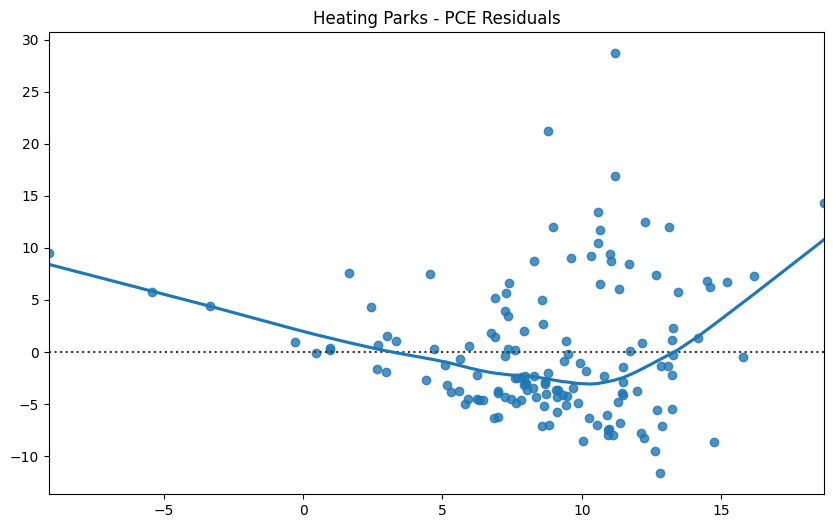

In [61]:
# Build separate regression models
def fit_group_model(df, group_name):
    """Fit full model for park group with diagnostics"""
    X = sm.add_constant(df[['ndvi_mean', 'pisi_mean', 'area_m2', 'LSI']])
    
    for target in ['PCI', 'PCA', 'PCE']:
        print(f"\n===== {group_name} Parks - {target} Model =====")
        model = OLS(df[target], X).fit()
        
        # Check model diagnostics
        if model.pvalues.max() > 0.05:
            print(f"Warning: Insignificant predictors in {target} model")
        
        print(model.summary())
        
        # Residual analysis
        plt.figure(figsize=(10,6))
        sns.residplot(x=model.predict(), y=model.resid, lowess=True)
        plt.title(f'{group_name} Parks - {target} Residuals')
        plt.show()
    
    return model

# Fit models for both groups
cooling_models = fit_group_model(data_df_cooling, "Cooling")
heating_models = fit_group_model(data_df_heating, "Heating")

In [62]:
from statsmodels.formula.api import ols

# Test interaction effects
interaction_model = ols('PCI ~ ndvi_mean * I(PCI<0) + area_m2 * I(PCI<0)', data_df).fit()
print(interaction_model.summary())

# If interaction terms are significant (p<0.05), separation is justified

                            OLS Regression Results                            
Dep. Variable:                    PCI   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     61.80
Date:                Thu, 24 Jul 2025   Prob (F-statistic):           5.07e-38
Time:                        01:47:29   Log-Likelihood:                -178.35
No. Observations:                 196   AIC:                             368.7
Df Residuals:                     190   BIC:                             388.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       